In [2]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE, ADASYN
from random import sample
from sklearn.metrics import classification_report

%matplotlib inline

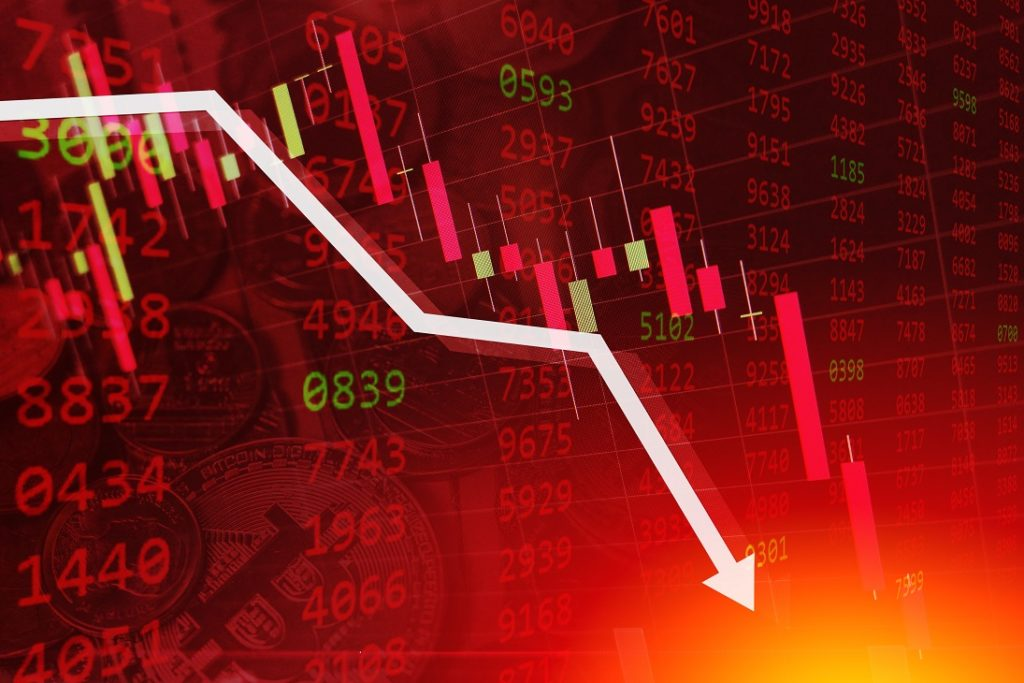

# Taiwanese Bankruptcy Prediction

>The purpose of this project is to predict whether a company is in bankruptcy due to its reported financials. The dataset was collected from the Taiwan Economic Journal for the years 1999-2009. A Deep Learning neural network model will be used as a binary classifier to predict if a company is in bankruptcy or not.

In [3]:
# Loading the path to the dataset

f = r'...\data.csv'

In [4]:
# Loading the dataset

company = pd.read_csv(f)

In [5]:
# Exploring the dataset

company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

>As shown by the info() method, we now know several important things about this dataset. The first is that there is no missing or null values, which saves us a lot of time. Secondly, all the the variables provided are numerical (int64 or float64). This helps with the model, which can't take categorical variables that are stored as strings or some other non-numeric datatype. Now we can continue to explore some other the aspects of the data.

In [6]:
company.shape

(6819, 96)

>Due to the shape of the dataset, we can determine that it contains data on 6819 companies. Each company has 95 variables associated with it, and one column used as a lable of whether the company is in bankruptcy or not.

In [7]:
# Sample of the data

company.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [8]:
# Descriptive statistics of the dataset

company.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [9]:
# checking to see if the classes in the dataset are imbalanced

p = 1-(len(company[company['Bankrupt?']==1])/len(company))
print(f"Percentage of non-bankrupt companies: {100*p:>8f}%")

Percentage of non-bankrupt companies: 96.773720%


In [10]:
# checking the imbalance 
company['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

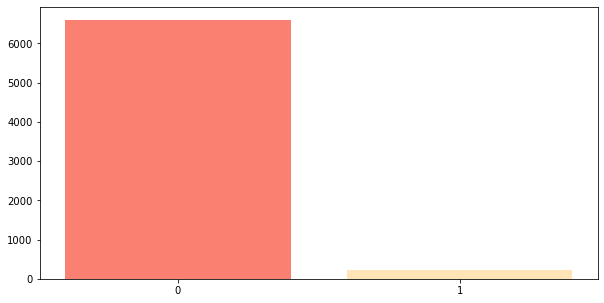

In [11]:
# Plotting the imbalance

u = list(company['Bankrupt?'].unique())
u.reverse()
vc = list(company['Bankrupt?'].value_counts())
plt.figure(figsize =(10,5))
plt.bar(u,vc, color = ['salmon', 'moccasin'])
plt.xticks(u)
plt.show()

>As you can see, there is a significant imbalance in the dataset. This will make it much harder for the model to seperate the two classes. Especially since the model will most likely classify all instances in the dataset as not bankrupt, which would still have a high accuracy score (96.77%). To deal with this imbalance, we will use the SMOTE resampling method. This will create synthetic samples of the smaller class that are similar to the the real class data, balancing the dataset between the two classes.

In [18]:
# Creating new synthetic data

X = company.drop('Bankrupt?', axis = 1).reset_index(drop = True)
y = company['Bankrupt?'].reset_index(drop = True)
X_resample, y_resample = SMOTE().fit_resample(X,y)

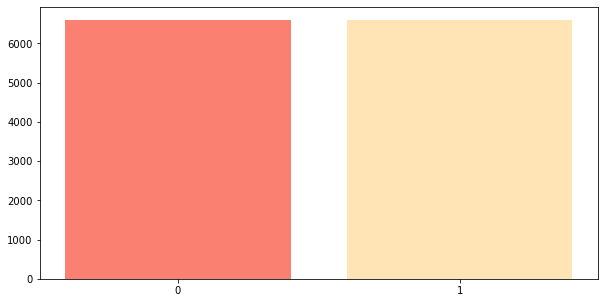

In [19]:
# Plotting the rebalanced dataset

plt.figure(figsize =(10,5))
plt.bar(u,y_resample.value_counts(), color = ['salmon', 'moccasin'])
plt.xticks(u)
plt.show()

In [20]:
# Showing that the dataset is now 50/50 between the two classes

y_resample.value_counts()

0    6599
1    6599
Name: Bankrupt?, dtype: int64

>Now that we have balanced the dataset, our model is still sensitive to highly correlated variables. These variables would overweight any signal from the data to the neural network. So, lets check the linear correlation of these variables using a heatmap

<AxesSubplot:>

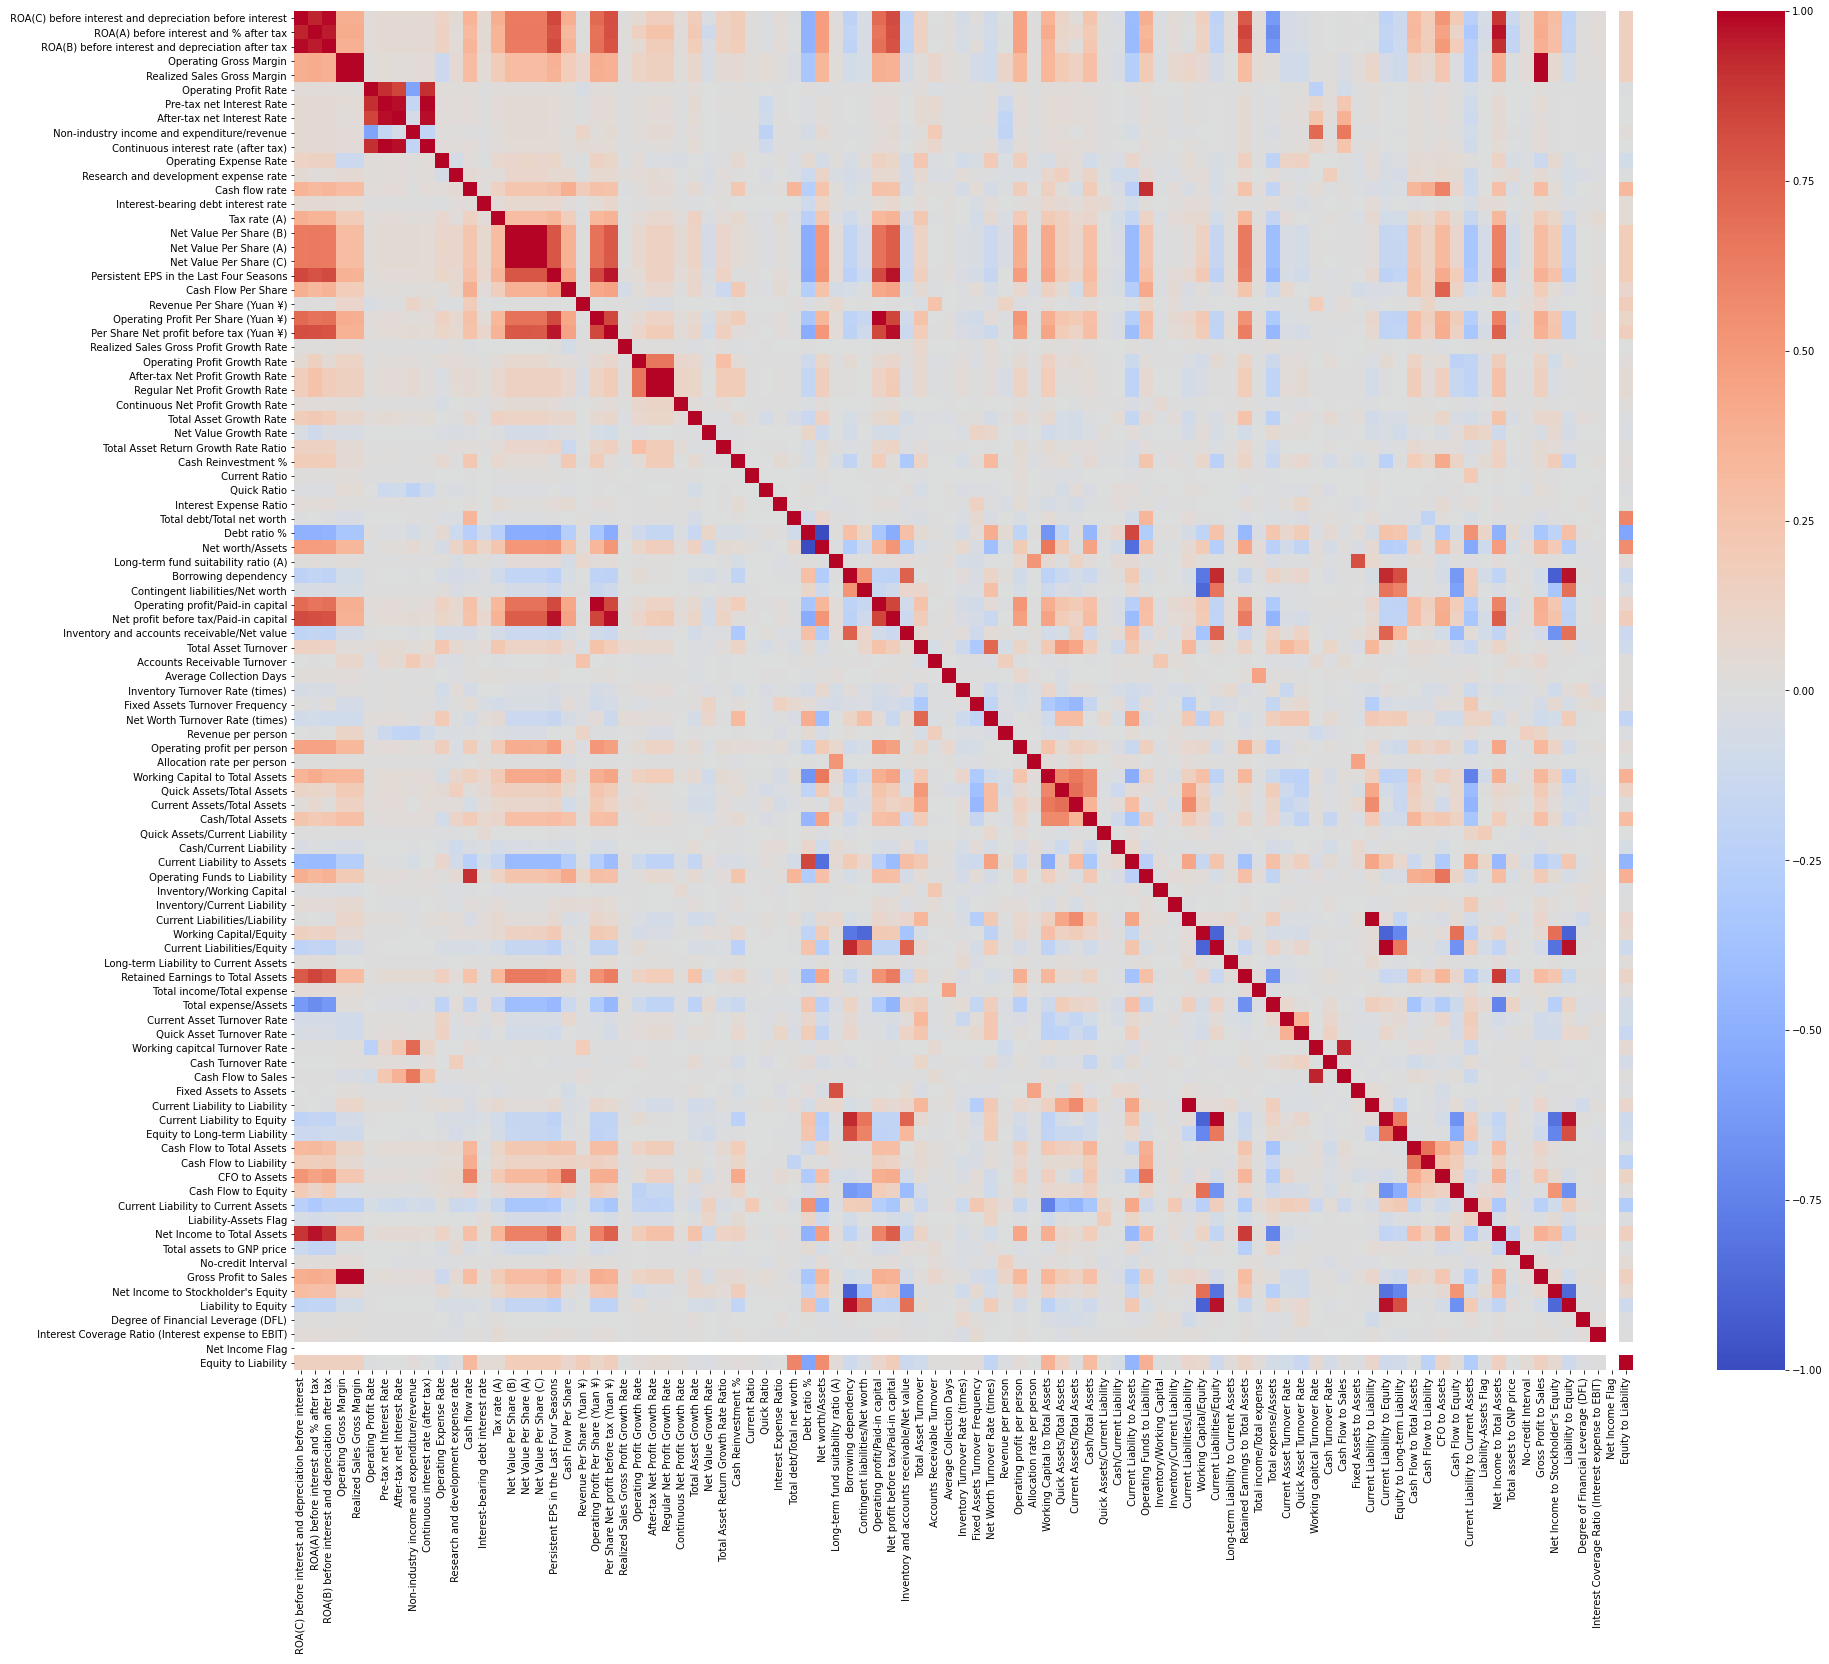

In [21]:
# Correlation matrix of dataset

plt.figure(figsize =(30,25))
sns.heatmap(X_resample.corr(), center = 0, cmap = 'coolwarm')

>This dataset isn't too bad, but there is some common correlation between some of the vaiables. Also, this heatmap doesn't show if a variable's variance is explained by multiple other variables, it just shows correlation between pairs of variables. Having a variable's variance that is expainable from multiple other vairables is called multicollinearity, and it causes the same problem as linear correlation by overweighting a signal to the neural network. To measure this multicollinearity, we will calculate the Variance Inflation Factor ( or VIF) for each of the variables in this dataset. A VIF of 1 is the minimum, and means no multicollinearity with the other variables. As the VIF increases, multicollinearity increases.

In [22]:
# Using the vif_data dataframe to show initial multicollinearity of the dataset

vif_data = pd.DataFrame()
vif_data['Features'] = X_resample.columns
vif_data['VIF'] = [variance_inflation_factor(X_resample.values, i) for i in range(len(X_resample.columns))]
print(vif_data)

                                             Features           VIF
0    ROA(C) before interest and depreciation befor...  1.106593e+02
1              ROA(A) before interest and % after tax  8.411802e+01
2    ROA(B) before interest and depreciation after...  1.988601e+02
3                              Operating Gross Margin  6.808212e+07
4                         Realized Sales Gross Margin  1.399968e+03
..                                                ...           ...
90                                Liability to Equity  1.947721e+03
91                 Degree of Financial Leverage (DFL)  1.043479e+00
92   Interest Coverage Ratio (Interest expense to ...  1.020712e+00
93                                    Net Income Flag  0.000000e+00
94                                Equity to Liability  4.532329e+00

[95 rows x 2 columns]


C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


> Now we will begin removing the highest VIF scores from the dataset. This is an iterative process, because everytime a variable is removed, the VIF scores of the other variables change. So, we will keep on removing variables and recalculating VIF scores until all variables in the dataset have a VIF below 2.8. 

In [23]:
# Removing highly related variables

while any(vif_data['VIF']>=2.8):
    i  = vif_data['VIF'].idxmax()
    X_resample.drop(X_resample.columns[i], axis = 1, inplace = True)
    X_resample.reset_index(drop =True)
    vif_data = pd.DataFrame()
    vif_data['Features'] = X_resample.columns
    vif_data['VIF'] = [variance_inflation_factor(X_resample.values, i) for i in range(len(X_resample.columns))]
print(vif_data)

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\

                                             Features       VIF
0                Continuous interest rate (after tax)  1.061507
1                              Operating Expense Rate  1.240093
2               Research and development expense rate  1.104924
3                                      Cash flow rate  2.270072
4                 Interest-bearing debt interest rate  1.020645
5                                        Tax rate (A)  1.228228
6                             Net Value Per Share (C)  1.946602
7                                 Cash Flow Per Share  1.607405
8                          Revenue Per Share (Yuan ¥)  1.256627
9             Realized Sales Gross Profit Growth Rate  1.019761
10                       Operating Profit Growth Rate  2.064059
11                     Regular Net Profit Growth Rate  2.023939
12                  Continuous Net Profit Growth Rate  1.025089
13                            Total Asset Growth Rate  1.126694
14                              Net Valu

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<AxesSubplot:>

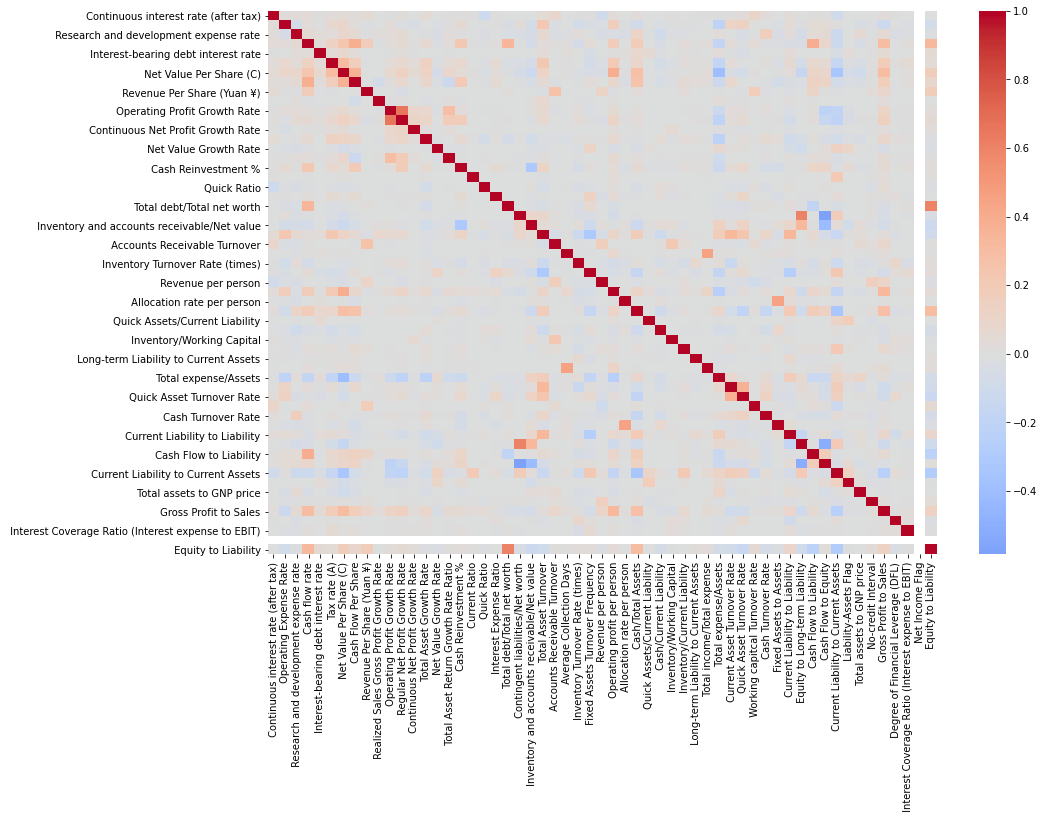

In [24]:
# Plotting the heatmap of the transformed data

plt.figure(figsize =(15,10))
sns.heatmap(X_resample.corr(), center = 0, cmap = 'coolwarm')

>As shown by the heatmap and VIF scores above, the linear correlation and multicollinearity between the variables have been reduced, and nothing in the dataset should overwieght any signal excessively. The next steps will include normalizing the data, making it easier for the model to learn, and seperating the data into train and test sets.

In [25]:
# Normalizing the data, saving column names for final classification metrics

c = X_resample.columns
scaler = StandardScaler()
X_resample = pd.DataFrame(scaler.fit_transform(X_resample), columns = X_resample.columns)

In [26]:
# recasting and spliting the data

X_resample = np.float32(X_resample)
y_resample = np.float32(y_resample)
X_train, X_test,y_train,y_test = train_test_split(X_resample,y_resample,test_size = 0.2, random_state=49)

> Now we will start building the train/test pipeline for the model. The first step will be creating a dataset object. This object will make it for the pytorch dataloader to split the data into small batches, making computation much easier.

In [27]:
# Creating the dataset object that will be used in the dataloader

class CreditDataset(Dataset):
    def __init__(self,X,y):
        self.labels = y
        self.X = X
    
    def __getitem__(self,index):
        return self.labels[index], self.X[index]
    
    def __len__(self):
        return len(self.X)
        

In [28]:
# Initializing the train and test dataloaders

train_dataloader = DataLoader(CreditDataset(X_train,y_train), batch_size = 64)
test_dataloader = DataLoader(CreditDataset(X_test,y_test), batch_size = 64)

>Now we are building the actual neural network. Most classification problems can be solved, as a rule of thumb, with 2 or 3 layers. Exceptions do exist (eg. Computervision), but given this problem is relatively straight foreward, we will only use 3 linear layers. The input to this model will be a 57 dimensional vector from each instance in the dataset, and the output will be a 2 dimensional vector that shows the probability of each company being in bankruptcy or not. ReLU will be used as the activation function, to make the neaural network non-linear. We will also use a dropout layer, which randomly drops a certain percentage of activations from the previous layer. This keeps the model from over relying on a specific varaible and prevents overfitting of the data. Ideally, all of this will improve the accuracy of the data. 

In [29]:
# Initializing the model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(57,57),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(57,57),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(57,2)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

> In the last step before we run the model, we need to define the train and test loops. These functions will update the model, allowing it to 'learn' the non-linear relationships between the varibles in the dataset and the probability of bankruptcy for a specific company. The train loop will use the loss and optimization fuctions to update the model, while the test loop will provide us insight into how the model is progressing.

In [30]:
# Creating the train loop

def train_loop(dataloader, model, loss_fn, optimizer):
    for y,x in dataloader:
        y_pred = model(x)
        loss = loss_fn(y_pred,y.type(torch.long))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [31]:
#Creating the test loop

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0,0
    with torch.no_grad():
        for y,x in dataloader:
            y_pred = model(x)
            test_loss += loss_fn(y_pred,y.type(torch.long))
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(correct*100):>8f}%, Avg loss: {test_loss:>8f} \n")
            

> Finally, we will initalize the model with all of its hyperparameters, and begin the running the train and test loops. The epochs are how many times the model will run against the dataset, in this case 500 times. We will be using pytorch's CrossEntropyLoss function (which combines a Negative Log Likelihood Loss function and a Softmax funtion) to measure the model's performance. Adam will be the optimizing function that actually updates the model's parameters.

In [32]:
# Initializing the hyperparameters and training the model

epochs = 500
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 87.651515%, Avg loss: 0.004835 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 90.151515%, Avg loss: 0.003971 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 92.310606%, Avg loss: 0.003307 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 93.068182%, Avg loss: 0.003177 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 93.787879%, Avg loss: 0.002893 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 93.977273%, Avg loss: 0.002652 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 94.734848%, Avg loss: 0.002427 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 94.886364%, Avg loss: 0.002267 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 95.151515%, Avg loss: 0.002215 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 95.492424%, Avg loss: 0.002265 

Epoch 11
--------------------

Test Error: 
 Accuracy: 98.484848%, Avg loss: 0.001459 

Epoch 86
-------------------------------
Test Error: 
 Accuracy: 98.143939%, Avg loss: 0.001325 

Epoch 87
-------------------------------
Test Error: 
 Accuracy: 97.992424%, Avg loss: 0.001362 

Epoch 88
-------------------------------
Test Error: 
 Accuracy: 98.560606%, Avg loss: 0.001361 

Epoch 89
-------------------------------
Test Error: 
 Accuracy: 98.181818%, Avg loss: 0.001197 

Epoch 90
-------------------------------
Test Error: 
 Accuracy: 98.219697%, Avg loss: 0.001305 

Epoch 91
-------------------------------
Test Error: 
 Accuracy: 98.712121%, Avg loss: 0.001241 

Epoch 92
-------------------------------
Test Error: 
 Accuracy: 98.371212%, Avg loss: 0.001148 

Epoch 93
-------------------------------
Test Error: 
 Accuracy: 98.560606%, Avg loss: 0.001227 

Epoch 94
-------------------------------
Test Error: 
 Accuracy: 98.446970%, Avg loss: 0.001684 

Epoch 95
-------------------------------
Test Error: 
 Accura

Test Error: 
 Accuracy: 98.409091%, Avg loss: 0.001731 

Epoch 169
-------------------------------
Test Error: 
 Accuracy: 98.787879%, Avg loss: 0.001370 

Epoch 170
-------------------------------
Test Error: 
 Accuracy: 98.712121%, Avg loss: 0.001407 

Epoch 171
-------------------------------
Test Error: 
 Accuracy: 98.939394%, Avg loss: 0.001065 

Epoch 172
-------------------------------
Test Error: 
 Accuracy: 98.560606%, Avg loss: 0.001267 

Epoch 173
-------------------------------
Test Error: 
 Accuracy: 98.901515%, Avg loss: 0.001119 

Epoch 174
-------------------------------
Test Error: 
 Accuracy: 98.750000%, Avg loss: 0.000843 

Epoch 175
-------------------------------
Test Error: 
 Accuracy: 98.636364%, Avg loss: 0.001345 

Epoch 176
-------------------------------
Test Error: 
 Accuracy: 98.484848%, Avg loss: 0.001062 

Epoch 177
-------------------------------
Test Error: 
 Accuracy: 98.901515%, Avg loss: 0.000989 

Epoch 178
-------------------------------
Test Error

Test Error: 
 Accuracy: 99.053030%, Avg loss: 0.001253 

Epoch 252
-------------------------------
Test Error: 
 Accuracy: 98.522727%, Avg loss: 0.001739 

Epoch 253
-------------------------------
Test Error: 
 Accuracy: 98.636364%, Avg loss: 0.001512 

Epoch 254
-------------------------------
Test Error: 
 Accuracy: 98.674242%, Avg loss: 0.001402 

Epoch 255
-------------------------------
Test Error: 
 Accuracy: 98.939394%, Avg loss: 0.001000 

Epoch 256
-------------------------------
Test Error: 
 Accuracy: 99.015152%, Avg loss: 0.001123 

Epoch 257
-------------------------------
Test Error: 
 Accuracy: 98.598485%, Avg loss: 0.001292 

Epoch 258
-------------------------------
Test Error: 
 Accuracy: 98.560606%, Avg loss: 0.001559 

Epoch 259
-------------------------------
Test Error: 
 Accuracy: 98.901515%, Avg loss: 0.001184 

Epoch 260
-------------------------------
Test Error: 
 Accuracy: 98.712121%, Avg loss: 0.001555 

Epoch 261
-------------------------------
Test Error

Test Error: 
 Accuracy: 99.128788%, Avg loss: 0.000715 

Epoch 335
-------------------------------
Test Error: 
 Accuracy: 98.977273%, Avg loss: 0.000644 

Epoch 336
-------------------------------
Test Error: 
 Accuracy: 99.242424%, Avg loss: 0.000766 

Epoch 337
-------------------------------
Test Error: 
 Accuracy: 99.015152%, Avg loss: 0.001297 

Epoch 338
-------------------------------
Test Error: 
 Accuracy: 98.863636%, Avg loss: 0.001500 

Epoch 339
-------------------------------
Test Error: 
 Accuracy: 98.977273%, Avg loss: 0.001423 

Epoch 340
-------------------------------
Test Error: 
 Accuracy: 98.636364%, Avg loss: 0.000853 

Epoch 341
-------------------------------
Test Error: 
 Accuracy: 98.901515%, Avg loss: 0.001331 

Epoch 342
-------------------------------
Test Error: 
 Accuracy: 99.090909%, Avg loss: 0.001332 

Epoch 343
-------------------------------
Test Error: 
 Accuracy: 98.939394%, Avg loss: 0.001211 

Epoch 344
-------------------------------
Test Error

Test Error: 
 Accuracy: 99.356061%, Avg loss: 0.001151 

Epoch 418
-------------------------------
Test Error: 
 Accuracy: 98.825758%, Avg loss: 0.001885 

Epoch 419
-------------------------------
Test Error: 
 Accuracy: 99.128788%, Avg loss: 0.001225 

Epoch 420
-------------------------------
Test Error: 
 Accuracy: 98.787879%, Avg loss: 0.001478 

Epoch 421
-------------------------------
Test Error: 
 Accuracy: 98.977273%, Avg loss: 0.001440 

Epoch 422
-------------------------------
Test Error: 
 Accuracy: 99.015152%, Avg loss: 0.001463 

Epoch 423
-------------------------------
Test Error: 
 Accuracy: 99.090909%, Avg loss: 0.001306 

Epoch 424
-------------------------------
Test Error: 
 Accuracy: 99.090909%, Avg loss: 0.001405 

Epoch 425
-------------------------------
Test Error: 
 Accuracy: 98.863636%, Avg loss: 0.001674 

Epoch 426
-------------------------------
Test Error: 
 Accuracy: 98.901515%, Avg loss: 0.001415 

Epoch 427
-------------------------------
Test Error

Test Error: 
 Accuracy: 99.015152%, Avg loss: 0.001716 

Done!


In [33]:
# Final Report

X_final = company[c]
y_pred_final = model(torch.from_numpy(np.float32(X_final.values)))
target_names = ['class 0','class 1']
print(classification_report(y,y_pred_final.argmax(1),target_names = target_names))


              precision    recall  f1-score   support

     class 0       0.97      1.00      0.98      6599
     class 1       0.33      0.00      0.01       220

    accuracy                           0.97      6819
   macro avg       0.65      0.50      0.50      6819
weighted avg       0.95      0.97      0.95      6819



> As shown above, the model was able to learn up to 99% accuracy with the synthetic data. However, with the final report, which only used the real-world data, the f1 scores were lower, significantly lower for the smaller class of bankrupt companies. The final weighted f1 score was 0.95, which is not terrible but not great either given the imbalance in the dataset. I would not recommend this model be used in a professional capacity to determine if a company is about to become bankrupt in the real world, due to the model's bias toward labeling a copmpany as not bankrupt. There are several opprotunities to improve the performance of this model. Some suggestions include experimenting with different synthetic data generation methods, changing the loss function to something that can better handle imbalanced data, as well as trying different machine learning classification models. However, the best path toward improving the model is probably collecting more real-world data on bankrupt, or near-bankrupt, companies to rebalance the dataset. This is also probably the most expensive way to improve the model.